In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%reset -f

In [ ]:
%cd /content/drive/MyDrive/permanent/RECHERCHE2/ml_flux_euler/

/content/drive/MyDrive/permanent/RECHERCHE2/ml_flux_euler


## import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
layers= tf.keras.layers

from Euler.param import Param, Projecter
from Euler.neural_networks import *
import popup_lib.popup as pop

import Euler.core_solver as core
import Euler.agent_addi as aga
import Euler.neural_networks as nn

from Euler.backend import K
from Euler.param import Param,Projecter
from Euler.initial_conditions import GenParam,FuncGenerator

import timeit
import pandas as pd

ModuleNotFoundError: ignored

## fonction pour mesure le temps

In [ ]:
def benchmark_helper(function_to_try,number_times=[10,50,100]):
    
    begin=time.time()
    tf_function_obj=tf.function(function_to_try)
    concrete_function=tf_function_obj.get_concrete_function()
    tracing_dur=time.time()-begin

    print("tracing:     ",tracing_dur)
    duration_with=[]
    for number in number_times:
        duration_with.append(timeit.timeit(concrete_function, number=number)/number)

    duration_without=[]
    for number in number_times:
        duration_without.append(timeit.timeit(function_to_try, number=number)/number)

    res=np.stack([duration_with,duration_without])
    res=pd.DataFrame(data=res,index=["with @","without"],columns=number_times)

    return res


In [ ]:
X=tf.random.uniform(shape=[20,30])

In [ ]:
model=tf.keras.Sequential()
model.add(layers.Dense(12,activation="relu"))
model.add(layers.Dense(100,activation="relu"))
model.add(layers.Dense(12,activation="relu"))

def call_simple_dense_model():
    return model(X)

res=call_simple_dense_model()
res.shape

TensorShape([20, 12])

In [ ]:
benchmark_helper(call_simple_dense_model)

tracing:      0.04781341552734375


,10,50,100
with @,0.001346,0.000343,0.000340
without,0.000788,0.000790,0.000825


## Padding, rolling etc.

In [ ]:
param=Param(nx=800)
param.BC_model=Param.BC_periodic
W=tf.random.uniform(shape=[param.batch_size,param.nx,param.augmentation_dim])

Param initialised with, nx=800, nx_coarse=79, batch_size=25


In [ ]:
def test_pad():
    res=pad(W,5,param)
benchmark_helper(test_pad)

tracing:      0.1547999382019043
                 10        50        100
with tf     0.000568  0.000177  0.000178
without tf  0.000282  0.000221  0.000221


In [ ]:
rolling_window_stacking(W,5).shape

TensorShape([25, 796, 5, 8])

In [ ]:
rolling_window(W,5).shape

(25, 796, 5, 8)

In [ ]:
benchmark_helper(lambda: pad_and_roll(W,5,param,True))

tracing:      0.16829848289489746
                 10        50        100
with tf     0.002673  0.001001  0.001003
without tf  0.047307  0.044610  0.044575


In [ ]:
%%time
pad_and_roll(W,5,param,False);
print("toto")

toto
CPU times: user 1.92 ms, sys: 1.05 ms, total: 2.97 ms
Wall time: 4.1 ms


## Compute solution

In [ ]:
k = K("tf", 32)
param = Param(1000, batch_size=64, BC_solver=Param.BC_reflexive)
genParam = GenParam(param,GenParam.kind_changing)
generator = FuncGenerator(genParam, param, k)
W = generator.init_W()
nb_t = 500

Param initialised with, nx=1000, nx_coarse=99, batch_size=64


In [ ]:
@tf.function
def compute_solution_accelerated():
    return core.compute_solutions(param, nb_t, W, False, k)

In [ ]:
%%time
compute_solution_accelerated()

In [ ]:
benchmark_helper(compute_solution_accelerated)

In [ ]:
## Projection

In [ ]:
benchmark_helper(compute_solution_accelerated)

In [ ]:
benchmark_helper(compute_solution_accelerated)

In [ ]:
## Projection

In [ ]:
benchmark_helper(compute_solution_accelerated)

CPU times: user 960 ms, sys: 19.9 ms, total: 980 ms
Wall time: 992 ms


(<tf.Tensor: shape=(0, 64, 1000, 3), dtype=float32, numpy=array([], shape=(0, 64, 1000, 3), dtype=float32)>,
 <tf.Tensor: shape=(0, 64, 1000, 3), dtype=float32, numpy=array([], shape=(0, 64, 1000, 3), dtype=float32)>)

In [ ]:
benchmark_helper(compute_solution_accelerated)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  File "<timeit-src>", line 6, in inner  File "<ipython-input-6-9debe9b69799>", line 3, in compute_solution_accelerated
    return core.compute_solutions(param, nb_t, W, False, k)  File "/content/drive/MyDrive/permanent/RECHERCHE2/ml_flux_euler/Euler/core_solver.py", line 292, in compute_solutions
    return compute_solutions_order1(param, nb_t, W_init, k,False)  File "/content/drive/MyDrive/permanent/RECHERCHE2/ml_flux_euler/Euler/core_solver.py", line 273, in compute_solutions_order1
    res.write(t,W)  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/tf_should_use.py", line 249, in wrapped
    error_in_function=error_in_function)
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "<timeit-src>", li

KeyboardInterrupt: ignored

In [ ]:
## Projection

In [ ]:
benchmark_helper(compute_solution_accelerated)

tracing:      0.23312854766845703


,10,50,100
with @,0.001534,0.000244,0.000247
without,0.001440,0.000267,0.000260


## Projection

In [ ]:
param=Param()
projecter=Projecter(param.nx_ratio,32)
W=tf.random.uniform(shape=[param.batch_size,param.nx,param.augmentation_dim])
res=projecter.projection(W)
res.shape

Param initialised with, nx=2000, nx_coarse=199, batch_size=25


TensorShape([25, 199, 8])

In [ ]:
benchmark_helper(lambda: projecter.projection(W))

tracing:      0.1188819408416748


,10,50,100
with @,0.001494,0.000343,0.000367
without,0.001139,0.000934,0.000960


## Call model

In [ ]:
param=Param(nx=800)
param.BC_model=Param.BC_periodic
W=tf.random.uniform(shape=[param.batch_size,param.nx,param.augmentation_dim])

Param initialised with, nx=800, nx_coarse=79, batch_size=25


### Model rolled

In [ ]:
model_rolled=Difference_model_addi(param,5,roll_via_stacking=True)
model_rolled(W).shape

TensorShape([25, 800, 3])

In [ ]:
@tf.function
def call_model_rolled():
    return model_rolled(W)

In [ ]:
benchmark_helper(call_model_rolled)

TypeError: ignored

In [ ]:
model_rolled_via_np_view=Difference_model_addi(param,5,roll_via_stacking=True)

In [ ]:
ti0=time.time()
for _ in range(100):
    model_rolled_via_np_view(W)
(time.time()-ti0)/100

0.008559186458587647

### Model convo

In [ ]:
model_tricky=Difference_model_tricky(param,5)
model_tricky(W);

In [ ]:
benchmark_helper(lambda: model_tricky(W))

tracing:      1.0631792545318604


,10,50,100
with @,0.012343,0.000690,0.001157
without,0.008223,0.008565,0.008270


## Optimisation

In [ ]:
param=Param(nx=800)
param.BC_model=Param.BC_periodic
W=tf.random.uniform(shape=[param.batch_size,param.nx,param.augmentation_dim])

Param initialised with, nx=800, nx_coarse=79, batch_size=25


J'ai essayé de n'accélérer que l'appel du modèle. C'est mieux que rien, mais c'est moins bien que l'accélération du tout minimize.

    @tf.function
    def call_model(X):
        return model_tricky(X)

In [ ]:
@tf.function
def minimize(model,X,optimizer):
    with tf.GradientTape() as tape:
        Y=model(X)
        loss=tf.reduce_mean(tf.abs(Y))
    gradients=tape.gradient(loss,model.keras_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients,model.keras_model.trainable_variables))
    return loss

In [ ]:
model_tricky=Difference_model_tricky(param,5,return_zeros=False)
optimizer=tf.keras.optimizers.Adam()

    %%time
    res=call_model(model_tricky,W)

In [ ]:
%%time
minimize(model_tricky,W,optimizer)

CPU times: user 429 ms, sys: 7.27 ms, total: 436 ms
Wall time: 442 ms


<tf.Tensor: shape=(), dtype=float32, numpy=0.1099292>

In [ ]:
%%time
losses_tricky=[]
for _ in range(300):
    loss=minimize(model_tricky,W,optimizer)
    losses_tricky.append(loss)

CPU times: user 481 ms, sys: 120 ms, total: 601 ms
Wall time: 591 ms


### stacked model

Malgré beaucoup d'effort, pour le modèle rolled, je n'ai pas réussit à utiliser l'accélération. Il y a une création de tf.Variable cachée quelque part...



In [ ]:
def minimize(model,X,optimizer):
    with tf.GradientTape() as tape:
        Y=model(X)
        loss=tf.reduce_mean(tf.abs(Y))
    gradients=tape.gradient(loss,model.keras_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients,model.keras_model.trainable_variables))
    return loss

In [ ]:
model_rolled=Difference_model_tricky(param,5,return_zeros=False)
optimizer=tf.keras.optimizers.Adam()

In [ ]:
%%time
losses_rolled=[]
for _ in range(300):
    loss=minimize(model_rolled,W,optimizer)
    losses_rolled.append(loss)

CPU times: user 4.62 s, sys: 39.3 ms, total: 4.66 s
Wall time: 4.66 s


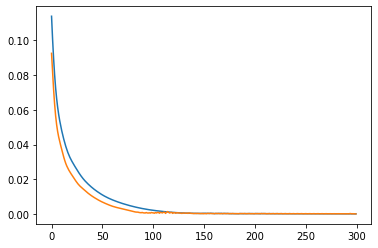

In [ ]:
plt.plot(losses_tricky)
plt.plot(losses_rolled)

## With loop

In [ ]:
param=Param(nx=800)
param.BC_model=Param.BC_periodic
W=tf.random.uniform(shape=[param.batch_size,param.nx,param.augmentation_dim])

Param initialised with, nx=800, nx_coarse=79, batch_size=25


In [ ]:
@tf.function
def call_model(model,X):
    return model(X)

Deux fois plus rapide de mettre `@tf.function` sur toute la fonction minimize

In [ ]:
@tf.function
def minimize_several_steps(model,X,optimizer,nb_step):
    losses=tf.TensorArray(tf.float32, size=0, dynamic_size=True, clear_after_read=False)
    for i in tf.range(nb_step):
        with tf.GradientTape() as tape:
            Y=model(X)#call_model(model,X)#
            loss=tf.reduce_mean(tf.abs(Y))
        losses=losses.write(i,loss)
        gradients=tape.gradient(loss,model.keras_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients,model.keras_model.trainable_variables))
    return losses.stack()

In [ ]:
model_tricky=Difference_model_tricky(param,5,return_zeros=False)
optimizer=tf.keras.optimizers.Adam()

In [ ]:
%%time
minimize_several_steps_concrete=minimize_several_steps.get_concrete_function(model_tricky,W,optimizer,tf.constant(1))
print(minimize_several_steps_concrete)

ConcreteFunction minimize_several_steps(model=<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f51a2987f10>, X, optimizer=<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f51a2987d10>, nb_step)
  Args:
    X: float32 Tensor, shape=(25, 800, 8)
    nb_step: int32 Tensor, shape=()
  Returns:
    float32 Tensor, shape=(None,)
CPU times: user 411 ms, sys: 7.52 ms, total: 418 ms
Wall time: 420 ms


In [ ]:
%%time
#pour le tracing
losses=minimize_several_steps(model_tricky,W,optimizer,tf.constant(1))

CPU times: user 86.1 ms, sys: 2.8 ms, total: 88.9 ms
Wall time: 90 ms


In [ ]:
minimize_several_steps.pretty_printed_concrete_signatures

<bound method Function.pretty_printed_concrete_signatures of <tensorflow.python.eager.def_function.Function object at 0x7f51a29c6b10>>

In [ ]:
%%time
losses=minimize_several_steps(model_tricky,W,optimizer,tf.constant(100))

CPU times: user 204 ms, sys: 8.74 ms, total: 213 ms
Wall time: 276 ms


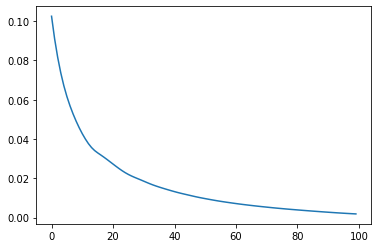

In [ ]:
plt.plot(losses)

In [ ]:
%%time
minimize_several_steps(model_tricky,W,optimizer,tf.constant(1000))

CPU times: user 1.56 s, sys: 123 ms, total: 1.68 s
Wall time: 2.25 s


In [ ]:
@tf.function
def fibonacci(n):
  ta = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
  ta = ta.unstack([0., 1.])

  for i in range(2, n):
    ta = ta.write(i, ta.read(i - 1) + ta.read(i - 2))

  return ta.stack()

fibonacci(7)

<tf.Tensor: shape=(7,), dtype=float32, numpy=array([0., 1., 1., 2., 3., 5., 8.], dtype=float32)>

## TOUT Accelérer 

### Agent

In [ ]:
class Agent_addi(pop.Abstract_Agent):

    def __init__(self, param: Param, model,
                 lossCoef_stab=1,
                 lossCoef_ridge=1e-1,
                 lossCoef_disHLL=0.1,
                 train_batch_size=256,
                 nb_optimization=20,
                 watch_duration=5  # durée pendant laquelle on observe la dynamique
                 ):

        self.famparams = {
            "lossCoef_stab": lossCoef_stab,
            "lossCoef_ridge": lossCoef_ridge,
            "lossCoef_disHLL": lossCoef_disHLL,
            "watch_duration": watch_duration
        }

        self.param = param
        self.model: nn.Difference_model_addi = model
        self.train_batch_size = train_batch_size
        self.nb_optimization = nb_optimization

        self.k_32 = K("tf", 32)
        self.optimizer = tf.keras.optimizers.Adam(1e-3)

    def set_and_perturb_famparams(self, famparam, period_count: int):
        self.famparams = famparam
        self.famparams["lossCoef_stab"] *= np.random.choice([0.7, 1.5])
        self.famparams["lossCoef_ridge"] *= np.random.choice([0.7, 1.5])
        self.famparams["lossCoef_disHLL"] *= np.random.choice([0.7, 1.5])
    
        watch_duration = self.famparams["watch_duration"] + np.random.choice([-2, 2])
        watch_duration = np.clip(watch_duration, 4, len(self.W_val) - 1)
        self.famparams["watch_duration"] = watch_duration

    def perturb_famparams_on_decadence(self, period_count):
        # c'est le seul coef qui fait quelque chose contre le sur-apprentissage
        self.famparams["lossCoef_ridge"] *= 1.5
        # on imagine qu'on est tombé dans un minimum local. On augmente les learning rate pour en sortir
        self.famparams["lossCoef_disHLL"] *= 1.5
        self.famparams["lossCoef_stab"] *= 1.5
       
    def _load_WY(self, W, Y):
        nb_t = len(W)
        assert nb_t > self.famparams["watch_duration"] + 1, f"le nb_t:{nb_t} est trop petit par rapport à self.watch_duration: {self.famparams['watch_duration']}"
        assert W.shape == (nb_t, self.param.batch_size, self.param.nx, 3)
        # Y est une différence de flux, donc sa longueur en  x est  param.nx
        assert Y.shape == (nb_t, self.param.batch_size, self.param.nx, 3), "Y.shape is:" + str(Y.shape)
        self.k_32.check_mine(W)
        self.k_32.check_mine(Y)

        projecteur = core.Projecter(self.param.nx_ratio, 32)
        W_proj = []
        Y_proj = []
        for x, y in zip(W, Y):
            W_proj.append(projecteur.projection(x))
            Y_proj.append(projecteur.projection(y))
        W_proj = tf.stack(W_proj)
        Y_proj = tf.stack(Y_proj)

        return W, Y, W_proj, Y_proj

    def load_WY_valid(self, W, Y):
        self.W_val, self.Y_val, self.W_val_proj, Y_val_proj = self._load_WY(W, Y)

    def load_WY_train(self, W, Y):
        self.W_train, self.Y_train, self.W_train_proj, self.Y_train_proj = self._load_WY(W, Y)

    def select_time_and_batch(self, W, Y, batch_size):
        nb_t = len(W)

        # tirage des temps
        t_init = np.random.randint(0, nb_t - self.famparams["watch_duration"] - 1, size=batch_size)
        t_final = t_init + self.famparams["watch_duration"]
        # tirages de batch
        rand_b = np.random.randint(0, self.param.batch_size, batch_size)

        pair_init = tf.stack([t_init, rand_b], axis=1)
        pair_final = tf.stack([t_final, rand_b], axis=1)

        w_init = tf.gather_nd(W, pair_init)
        w_final = tf.gather_nd(W, pair_final)

        y_init = tf.gather_nd(Y, pair_init)
        y_final = tf.gather_nd(Y, pair_final)

        return w_init, w_final, y_init, y_final

    def HLL_error(self):
        return self._error(False)

    def agent_score(self):
        HLL_error = self._error(False)
        agent_error = self._error(True)
        return HLL_error / agent_error

    def _error(self, is_model, return_Ws=False):
        if self.Y_val is None:
            raise Exception("Vous n'avez pas charger les données de validation")

        # on prend toutes les données disponibles (donc on n'utilise pas self.train_batch_size).
        # on prend les 2 temps les plus éloignés possibles (donc on n'utilise pas self.watch_duration)
        w_init = self.W_val[0, :, :, :]
        w_final = self.W_val[-1, :, :, :]

        projecteur = core.Projecter(self.param.nx_ratio, 32)
        w_final_projected = projecteur.projection(w_final)
        w_coarse = projecteur.projection(w_init)

        for t in range(len(self.W_val)):
            var = core.Var(w_coarse, self.param, self.k_32)
            Fnum_HLL = core.Flux_HLL(var, self.param, self.k_32)
            dFnum_HLL = (Fnum_HLL[:, 1:, :] - Fnum_HLL[:, :-1, :])

            if is_model:
                X = var.get_augmentation()
                addi = self.model(X)
                dFnum = dFnum_HLL + addi
            else:
                dFnum = dFnum_HLL

            w_coarse = w_coarse - self.param.dt_over_dx_coarse * dFnum

        # error = tf.reduce_mean(tf.abs((w_coarse - w_final_projected)))
        error = tf.reduce_mean((w_coarse - w_final_projected)**2)
        # error = tf.reduce_max(tf.abs((w_coarse - w_final_projected)))

        if return_Ws:
            return w_coarse, w_final_projected
        else:
            return error.numpy()

    def give_results(self, is_model):
        w_coarse, w_final_projected = self._error(is_model, True)
        return w_coarse, w_final_projected


    @tf.function
    def gradient_tape(self,w_coarse,w_final_projected,watch_duration,lossCoef_stab):
        print("Traçage de la méthode gradient_tape")




        with tf.GradientTape() as tape:

            for t in tf.range(watch_duration): #self.famparams["watch_duration"]
                var = core.Var(w_coarse, self.param, self.k_32)
                Fnum_HLL = core.Flux_HLL(var, self.param, self.k_32)
                dFnum_HLL = (Fnum_HLL[:, 1:, :] - Fnum_HLL[:, :-1, :])

                X = var.get_augmentation()
                addi = self.model(X)
                dFnum = dFnum_HLL + addi

                w_coarse = w_coarse - self.param.dt_over_dx_coarse * dFnum

            """ à la première itération (t=0) W est ici égal à W[t_init+1]
            donc à dernière itération (t=watch_duration-1), W vaut W[t_init+watch_duration]"""

            loss = tf.reduce_mean((w_coarse - w_final_projected) ** 2)
            loss *= lossCoef_stab #self.famparams["lossCoef_stab"]

        gradients = tape.gradient(loss, self.model.keras_model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.keras_model.trainable_variables))

        return loss


    def optimize(self):
        # self.loss_stab_forHistory, self.loss_disHLL_forHistory, self.loss_ridge_forHistory, self.loss_Laplacian_forHistory = 0, 0, 0, 0
        # self.loss_stab_forHistory, self.loss_disHLL_forHistory, self.loss_ridge_forHistory, self.loss_plateau_forHistory = 0, 0, 0, 0
        self.loss_stab_forHistory, self.loss_disHLL_forHistory, self.loss_ridge_forHistory = 0, 0, 0

        w_init, w_final, y_init, y_final = self.select_time_and_batch(self.W_train, self.Y_train, self.train_batch_size)

        projecteur = core.Projecter(self.param.nx_ratio, 32)
        w_coarse = projecteur.projection(w_init)
        w_final_projected=projecteur.projection(w_final)

        loss=self.gradient_tape(w_coarse,w_final_projected,
                                tf.constant(self.famparams["watch_duration"]),
                                tf.constant(self.famparams["lossCoef_stab"])
                                            )

        return loss.numpy()#self.loss_stab_forHistory, self.loss_disHLL_forHistory, self.loss_ridge_forHistory


    def to_register_at_period_end(self) -> Dict[str, float]:
        return {
            "loss_stab": self.loss_stab_forHistory,
            "loss_disHLL": self.loss_disHLL_forHistory,
            "loss_ridge": self.loss_ridge_forHistory,
            # "loss_Laplacian": self.loss_Laplacian_forHistory
            # "loss_plateau": self.loss_plateau_forHistory
        }
#

    def optimize_and_return_score(self) -> float:
        for _ in range(self.nb_optimization):
            self.optimize()
        return self.agent_score()

    def get_famparams(self):
        return self.famparams

    def set_weights(self, weights: List):
        self.model.keras_model.set_weights(weights)

    def get_copy_of_weights(self) -> List:
        return self.model.keras_model.get_weights()


In [ ]:
param=Param(nx=800,batch_size=64)
param.BC_model=Param.BC_periodic
k=K("tf",32)

In [ ]:
genParam=GenParam(param,kind=GenParam.kind_changing)
window_size=5
nb_t=200
order=1

In [ ]:
W_train, Y_train = core.generate_fine_solutions(genParam,param, nb_t,k)
W_val, Y_val = core.generate_fine_solutions(genParam,param, nb_t,k)
print()
print(W_train.shape)

model_struct = (32,64,32)
agent= Agent_addi(param, nn.Difference_model_tricky(param,window_size,model_struct=model_struct),
                            watch_duration=20,
                            lossCoef_stab=10.,
                            lossCoef_ridge=3e-3,
                            lossCoef_disHLL=1.,
                            nb_optimization=15,
                            )

In [ ]:
# class Agent_addi(pop.Abstract_Agent):

#     def __init__(self, param: Param, model,
#                  lossCoef_stab=1,
#                  lossCoef_ridge=1e-1,
#                  lossCoef_disHLL=0.1,
#                  train_batch_size=256,
#                  nb_optimization=20,
#                  watch_duration=5  # durée pendant laquelle on observe la dynamique
#                  ):

#         self.famparams = {
#             "lossCoef_stab": lossCoef_stab,
#             "lossCoef_ridge": lossCoef_ridge,
#             "lossCoef_disHLL": lossCoef_disHLL,
#             "watch_duration": watch_duration
#         }

#         self.param = param
#         self.model: nn.Difference_model_addi = model
#         self.train_batch_size = train_batch_size
#         self.nb_optimization = nb_optimization

#         self.k_32 = K("tf", 32)
#         self.optimizer = tf.keras.optimizers.Adam(1e-3)

#     def set_and_perturb_famparams(self, famparam, period_count: int):
#         self.famparams = famparam
#         self.famparams["lossCoef_stab"] *= np.random.choice([0.7, 1.5])
#         self.famparams["lossCoef_ridge"] *= np.random.choice([0.7, 1.5])
#         self.famparams["lossCoef_disHLL"] *= np.random.choice([0.7, 1.5])
    
#         watch_duration = self.famparams["watch_duration"] + np.random.choice([-2, 2])
#         watch_duration = np.clip(watch_duration, 4, len(self.W_val) - 1)
#         self.famparams["watch_duration"] = watch_duration

#     def perturb_famparams_on_decadence(self, period_count):
#         # c'est le seul coef qui fait quelque chose contre le sur-apprentissage
#         self.famparams["lossCoef_ridge"] *= 1.5
#         # on imagine qu'on est tombé dans un minimum local. On augmente les learning rate pour en sortir
#         self.famparams["lossCoef_disHLL"] *= 1.5
#         self.famparams["lossCoef_stab"] *= 1.5
       
#     def _load_WY(self, W, Y):
#         nb_t = len(W)
#         assert nb_t > self.famparams["watch_duration"] + 1, f"le nb_t:{nb_t} est trop petit par rapport à self.watch_duration: {self.famparams['watch_duration']}"
#         assert W.shape == (nb_t, self.param.batch_size, self.param.nx, 3)
#         # Y est une différence de flux, donc sa longueur en  x est  param.nx
#         assert Y.shape == (nb_t, self.param.batch_size, self.param.nx, 3), "Y.shape is:" + str(Y.shape)
#         self.k_32.check_mine(W)
#         self.k_32.check_mine(Y)

#         projecteur = core.Projecter(self.param.nx_ratio, 32)
#         W_proj = []
#         Y_proj = []
#         for x, y in zip(W, Y):
#             W_proj.append(projecteur.projection(x))
#             Y_proj.append(projecteur.projection(y))
#         W_proj = tf.stack(W_proj)
#         Y_proj = tf.stack(Y_proj)

#         return W, Y, W_proj, Y_proj

#     def load_WY_valid(self, W, Y):
#         self.W_val, self.Y_val, self.W_val_proj, Y_val_proj = self._load_WY(W, Y)

#     def load_WY_train(self, W, Y):
#         self.W_train, self.Y_train, self.W_train_proj, self.Y_train_proj = self._load_WY(W, Y)

#     def select_time_and_batch(self, W, Y, batch_size):
#         nb_t = len(W)

#         # tirage des temps
#         t_init = np.random.randint(0, nb_t - self.famparams["watch_duration"] - 1, size=batch_size)
#         t_final = t_init + self.famparams["watch_duration"]
#         # tirages de batch
#         rand_b = np.random.randint(0, self.param.batch_size, batch_size)

#         pair_init = tf.stack([t_init, rand_b], axis=1)
#         pair_final = tf.stack([t_final, rand_b], axis=1)

#         w_init = tf.gather_nd(W, pair_init)
#         w_final = tf.gather_nd(W, pair_final)

#         y_init = tf.gather_nd(Y, pair_init)
#         y_final = tf.gather_nd(Y, pair_final)

#         return w_init, w_final, y_init, y_final

#     def HLL_error(self):
#         return self._error(False)

#     def agent_score(self):
#         HLL_error = self._error(False)
#         agent_error = self._error(True)
#         return HLL_error / agent_error

#     def _error(self, is_model, return_Ws=False):
#         if self.Y_val is None:
#             raise Exception("Vous n'avez pas charger les données de validation")

#         # on prend toutes les données disponibles (donc on n'utilise pas self.train_batch_size).
#         # on prend les 2 temps les plus éloignés possibles (donc on n'utilise pas self.watch_duration)
#         w_init = self.W_val[0, :, :, :]
#         w_final = self.W_val[-1, :, :, :]

#         projecteur = core.Projecter(self.param.nx_ratio, 32)
#         w_final_projected = projecteur.projection(w_final)
#         w_coarse = projecteur.projection(w_init)

#         for t in range(len(self.W_val)):
#             var = core.Var(w_coarse, self.param, self.k_32)
#             Fnum_HLL = core.Flux_HLL(var, self.param, self.k_32)
#             dFnum_HLL = (Fnum_HLL[:, 1:, :] - Fnum_HLL[:, :-1, :])

#             if is_model:
#                 X = var.get_augmentation()
#                 addi = self.model(X)
#                 dFnum = dFnum_HLL + addi
#             else:
#                 dFnum = dFnum_HLL

#             w_coarse = w_coarse - self.param.dt_over_dx_coarse * dFnum

#         # error = tf.reduce_mean(tf.abs((w_coarse - w_final_projected)))
#         error = tf.reduce_mean((w_coarse - w_final_projected)**2)
#         # error = tf.reduce_max(tf.abs((w_coarse - w_final_projected)))

#         if return_Ws:
#             return w_coarse, w_final_projected
#         else:
#             return error.numpy()

#     def give_results(self, is_model):
#         w_coarse, w_final_projected = self._error(is_model, True)
#         return w_coarse, w_final_projected


#     @tf.function
#     def gradient_tape(self,w_coarse,w_final_projected,watch_duration,lossCoef_stab):
#         print("Traçage de la méthode gradient_tape")

#         with tf.GradientTape() as tape:

#             for t in tf.range(watch_duration): #self.famparams["watch_duration"]
#                 var = core.Var(w_coarse, self.param, self.k_32)
#                 Fnum_HLL = core.Flux_HLL(var, self.param, self.k_32)
#                 dFnum_HLL = (Fnum_HLL[:, 1:, :] - Fnum_HLL[:, :-1, :])

#                 X = var.get_augmentation()
#                 addi = self.model(X)
#                 dFnum = dFnum_HLL + addi

#                 w_coarse = w_coarse - self.param.dt_over_dx_coarse * dFnum

#             """ à la première itération (t=0) W est ici égal à W[t_init+1]
#             donc à dernière itération (t=watch_duration-1), W vaut W[t_init+watch_duration]"""

#             loss = tf.reduce_mean((w_coarse - w_final_projected) ** 2)
#             loss *= lossCoef_stab #self.famparams["lossCoef_stab"]

#         gradients = tape.gradient(loss, self.model.keras_model.trainable_variables)
#         self.optimizer.apply_gradients(zip(gradients, self.model.keras_model.trainable_variables))

#         return loss


#     def optimize(self):
#         # self.loss_stab_forHistory, self.loss_disHLL_forHistory, self.loss_ridge_forHistory, self.loss_Laplacian_forHistory = 0, 0, 0, 0
#         # self.loss_stab_forHistory, self.loss_disHLL_forHistory, self.loss_ridge_forHistory, self.loss_plateau_forHistory = 0, 0, 0, 0
#         self.loss_stab_forHistory, self.loss_disHLL_forHistory, self.loss_ridge_forHistory = 0, 0, 0

#         w_init, w_final, y_init, y_final = self.select_time_and_batch(self.W_train, self.Y_train, self.train_batch_size)

#         projecteur = core.Projecter(self.param.nx_ratio, 32)
#         w_coarse = projecteur.projection(w_init)
#         w_final_projected=projecteur.projection(w_final)

#         loss=self.gradient_tape(w_coarse,w_final_projected,
#                                 tf.constant(self.famparams["watch_duration"]),
#                                 tf.constant(self.famparams["lossCoef_stab"])
#                                             )

#         return loss.numpy()#self.loss_stab_forHistory, self.loss_disHLL_forHistory, self.loss_ridge_forHistory


#     def to_register_at_period_end(self) -> Dict[str, float]:
#         return {
#             "loss_stab": self.loss_stab_forHistory,
#             "loss_disHLL": self.loss_disHLL_forHistory,
#             "loss_ridge": self.loss_ridge_forHistory,
#             # "loss_Laplacian": self.loss_Laplacian_forHistory
#             # "loss_plateau": self.loss_plateau_forHistory
#         }
# #

#     def optimize_and_return_score(self) -> float:
#         for _ in range(self.nb_optimization):
#             self.optimize()
#         return self.agent_score()

#     def get_famparams(self):
#         return self.famparams

#     def set_weights(self, weights: List):
#         self.model.keras_model.set_weights(weights)

#     def get_copy_of_weights(self) -> List:
#         return self.model.keras_model.get_weights()


In [ ]:

class Agent_addi(pop.Abstract_Agent):

    def __init__(self, param: Param, model,
                 lossCoef_stab=1.,
                 lossCoef_ridge=1e-1,
                 lossCoef_disHLL=0.1,
                 train_batch_size=256,
                 nb_optimization=20,
                 watch_duration=5  # durée pendant laquelle on observe la dynamique
                 ):

        self.famparams = {
            "lossCoef_stab": lossCoef_stab,
            "lossCoef_ridge": lossCoef_ridge,
            "lossCoef_disHLL": lossCoef_disHLL,
            "watch_duration": watch_duration
        }

        self.param = param
        self.model: nn.Difference_model_addi = model
        self.train_batch_size = train_batch_size
        self.nb_optimization = nb_optimization

        self.k_32 = K("tf", 32)
        self.optimizer = tf.keras.optimizers.Adam(1e-3)

    def set_and_perturb_famparams(self, famparam, period_count: int):
        self.famparams = famparam
        self.famparams["lossCoef_stab"] *= np.random.choice([0.7, 1.5])
        self.famparams["lossCoef_ridge"] *= np.random.choice([0.7, 1.5])
        self.famparams["lossCoef_disHLL"] *= np.random.choice([0.7, 1.5])

        watch_duration = self.famparams["watch_duration"] + np.random.choice([-2, 2])
        watch_duration = np.clip(watch_duration, 4, len(self.W_val) - 1)
        self.famparams["watch_duration"] = watch_duration

    def perturb_famparams_on_decadence(self, period_count):
        # c'est le seul coef qui fait quelque chose contre le sur-apprentissage
        self.famparams["lossCoef_ridge"] *= 1.5
        # on imagine qu'on est tombé dans un minimum local. On augmente les learning rate pour en sortir
        self.famparams["lossCoef_disHLL"] *= 1.5
        self.famparams["lossCoef_stab"] *= 0.5

    def _load_WY(self, W, Y):
        nb_t = len(W)
        assert nb_t > self.famparams[
            "watch_duration"] + 1, f"le nb_t:{nb_t} est trop petit par rapport à self.watch_duration: {self.famparams['watch_duration']}"
        assert W.shape == (nb_t, self.param.batch_size, self.param.nx, 3)
        # Y est une différence de flux, donc sa longueur en  x est  param.nx
        assert Y.shape == (nb_t, self.param.batch_size, self.param.nx, 3), "Y.shape is:" + str(Y.shape)
        self.k_32.check_mine(W)
        self.k_32.check_mine(Y)

        projecteur = core.Projecter(self.param.nx_ratio, 32)
        W_proj = []
        Y_proj = []
        for x, y in zip(W, Y):
            W_proj.append(projecteur.projection(x))
            Y_proj.append(projecteur.projection(y))
        W_proj = tf.stack(W_proj)
        Y_proj = tf.stack(Y_proj)

        return W, Y, W_proj, Y_proj

    def load_WY_valid(self, W, Y):
        self.W_val, self.Y_val, self.W_val_proj, Y_val_proj = self._load_WY(W, Y)

    def load_WY_train(self, W, Y):
        self.W_train, self.Y_train, self.W_train_proj, self.Y_train_proj = self._load_WY(W, Y)


    def select_time_and_batch(self, W, Y, batch_size):
        nb_t = len(W)

        # tirage des temps
        t_init = np.random.randint(0, nb_t - self.famparams["watch_duration"] - 1, size=batch_size)
        t_final = t_init + self.famparams["watch_duration"]
        # tirages de batch
        rand_b = np.random.randint(0, self.param.batch_size, batch_size)

        pair_init = tf.stack([t_init, rand_b], axis=1)
        pair_final = tf.stack([t_final, rand_b], axis=1)

        w_init = tf.gather_nd(W, pair_init)
        w_final = tf.gather_nd(W, pair_final)

        y_init = tf.gather_nd(Y, pair_init)
        y_final = tf.gather_nd(Y, pair_final)

        return w_init, w_final, y_init, y_final

    def HLL_error(self):
        return self._error(False)

    def agent_score(self):
        HLL_error = self._error(False)
        agent_error = self._error(True)
        return HLL_error / agent_error


    def _error(self, is_model, return_Ws=False):

        if self.Y_val is None:
            raise Exception("Vous n'avez pas charger les données de validation")

        # on prend toutes les données disponibles (donc on n'utilise pas self.train_batch_size).
        # on prend les 2 temps les plus éloignés possibles (donc on n'utilise pas self.watch_duration)
        w_init = self.W_val[0, :, :, :]
        w_final = self.W_val[-1, :, :, :]

        projecteur = core.Projecter(self.param.nx_ratio, 32)
        w_final_projected = projecteur.projection(w_final)
        w_coarse = projecteur.projection(w_init)

        for t in range(len(self.W_val)):
            var = core.Var(w_coarse, self.param, self.k_32)
            Fnum_HLL = core.Flux_HLLC(var, self.param, self.k_32)
            dFnum_HLL = (Fnum_HLL[:, 1:, :] - Fnum_HLL[:, :-1, :])

            if is_model:
                X = var.get_augmentation()
                addi = self.model(X)
                dFnum = dFnum_HLL + addi
            else:
                dFnum = dFnum_HLL

            w_coarse = w_coarse - self.param.dt_over_dx_coarse * dFnum

        # error = tf.reduce_mean(tf.abs((w_coarse - w_final_projected)))
        error = tf.reduce_mean((w_coarse - w_final_projected) ** 2)
        # error = tf.reduce_max(tf.abs((w_coarse - w_final_projected)))

        if return_Ws:
            return w_coarse, w_final_projected
        else:
            return error.numpy()

    def give_results(self, is_model):
        w_coarse, w_final_projected = self._error(is_model, True)
        return w_coarse, w_final_projected

    @tf.function
    def gradient_tape(self, w_coarse, w_final_projected, watch_duration, lossCoef_stab,lossCoef_disHLL,lossCoef_ridge):
        print("Traçage de la méthode gradient_tape")

        with tf.GradientTape() as tape:
            dist_to_HLL = tf.constant(0.)
            for _ in tf.range(watch_duration):
                var = core.Var(w_coarse, self.param, self.k_32)
                Fnum_HLL = core.Flux_HLLC(var, self.param, self.k_32)
                dFnum_HLL = (Fnum_HLL[:, 1:, :] - Fnum_HLL[:, :-1, :])

                X = var.get_augmentation()
                addi = self.model(X)
                dFnum = dFnum_HLL + addi


                if lossCoef_disHLL > 1e-6:
                    dist_to_HLL += tf.reduce_mean(addi**2)

                w_coarse = w_coarse - self.param.dt_over_dx_coarse * dFnum

            """ à la première itération (t=0) W est ici égal à W[t_init+1]
            donc à dernière itération (t=watch_duration-1), W vaut W[t_init+watch_duration]"""

            loss_stab_forHistory = tf.reduce_mean((w_coarse - w_final_projected) ** 2)
            loss = loss_stab_forHistory*lossCoef_stab

            loss_disHLL_forHistory=tf.constant(0.)
            if lossCoef_disHLL > 1e-6:
                # pour faire une moyenne temporelle on divise par la watch duration
                loss_disHLL_forHistory=dist_to_HLL/ watch_duration
                loss += loss_disHLL_forHistory*lossCoef_disHLL


            loss_ridge_forHistory=tf.constant(0.)
            ridge_term=tf.constant(0.)
            if  lossCoef_ridge> 1e-6:
                ridge_term = tf.constant(0.)
                nb_var = tf.constant(0.)
                for var in self.model.keras_model.trainable_variables:
                    if len(var.shape) == 2:  # pour ne pas prendre les biais
                        nb_var += var.shape[0] * var.shape[1]
                        ridge_term += tf.reduce_sum(var ** 2)
                # on divise par sqrt(nombre_de_variable) pour avoir toujours le même ordre de grandeur
                # quelque soit la structure (théorème central limite)
                loss_ridge_forHistory = ridge_term / tf.sqrt(nb_var)
                loss += loss_ridge_forHistory*lossCoef_ridge


        gradients = tape.gradient(loss, self.model.keras_model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.keras_model.trainable_variables))

        return loss_stab_forHistory, loss_disHLL_forHistory, loss_ridge_forHistory


    def optimize(self):
        # self.loss_stab_forHistory, self.loss_disHLL_forHistory, self.loss_ridge_forHistory, self.loss_Laplacian_forHistory = 0, 0, 0, 0
        # self.loss_stab_forHistory, self.loss_disHLL_forHistory, self.loss_ridge_forHistory, self.loss_plateau_forHistory = 0, 0, 0, 0
        self.loss_stab_forHistory, self.loss_disHLL_forHistory, self.loss_ridge_forHistory = 0, 0, 0

        w_init, w_final, y_init, y_final = self.select_time_and_batch(self.W_train, self.Y_train, self.train_batch_size)

        projecteur = core.Projecter(self.param.nx_ratio, 32)
        w_coarse = projecteur.projection(w_init)
        w_final_projected = projecteur.projection(w_final)

        self.loss_stab_forHistory, self.loss_disHLL_forHistory, self.loss_ridge_forHistory = self.gradient_tape(w_coarse, w_final_projected,
                                  tf.constant(self.famparams["watch_duration"],tf.float32),
                                  tf.constant(self.famparams["lossCoef_stab"],tf.float32),
                                  tf.constant(self.famparams["lossCoef_disHLL"],tf.float32),
                                  tf.constant(self.famparams["lossCoef_ridge"],tf.float32)
                                  )
        self.loss_stab_forHistory, self.loss_disHLL_forHistory, self.loss_ridge_forHistory=self.loss_stab_forHistory.numpy(), self.loss_disHLL_forHistory.numpy(), self.loss_ridge_forHistory.numpy()

        return self.loss_stab_forHistory, self.loss_disHLL_forHistory, self.loss_ridge_forHistory


    def to_register_at_period_end(self) -> Dict[str, float]:
        return {
            "loss_stab": self.loss_stab_forHistory,
            "loss_disHLL": self.loss_disHLL_forHistory,
            "loss_ridge": self.loss_ridge_forHistory,
            # "loss_Laplacian": self.loss_Laplacian_forHistory
            # "loss_plateau": self.loss_plateau_forHistory
        }

    #

    def optimize_and_return_score(self) -> float:
        for _ in range(self.nb_optimization):
            self.optimize()
        return self.agent_score()

    def get_famparams(self):
        return self.famparams

    def set_weights(self, weights: List):
        self.model.keras_model.set_weights(weights)

    def get_copy_of_weights(self) -> List:
        return self.model.keras_model.get_weights()


In [ ]:
param=Param(nx=800,batch_size=64)
param.BC_model=Param.BC_periodic
k=K("tf",32)

Param initialised with, nx=800, nx_coarse=79, batch_size=64


In [ ]:
genParam=GenParam(param,kind=GenParam.kind_changing)
window_size=5
nb_t=200
order=1

In [ ]:
@tf.function
def generate():
    return core.generate_fine_solutions(genParam,param, nb_t,k)

In [ ]:
%%time
generate()

KeyboardInterrupt: ignored

In [ ]:
%%time
W_train, Y_train = core.generate_fine_solutions(genParam,param, nb_t,k)
W_val, Y_val = core.generate_fine_solutions(genParam,param, nb_t,k)
print()
print(W_train.shape)


(200, 64, 800, 3)
CPU times: user 2.08 s, sys: 0 ns, total: 2.08 s
Wall time: 2.08 s


In [ ]:
model_struct = (32,64,32)
agent= Agent_addi(param, nn.Difference_model_tricky(param,window_size,model_struct=model_struct),
                            watch_duration=20,
                            lossCoef_stab=10.,
                            lossCoef_ridge=3e-3,
                            lossCoef_disHLL=1.,
                            nb_optimization=15,
                            )

In [ ]:
agent.load_WY_train(W_train, Y_train)
agent.load_WY_valid(W_val, Y_val)

In [ ]:
tf.config.run_functions_eagerly(False)

In [ ]:
%%time
losses=[]
losses.append(agent.optimize())

Traçage de la méthode gradient_tape
Traçage de la méthode gradient_tape
CPU times: user 4.78 s, sys: 212 ms, total: 4.99 s
Wall time: 4.98 s


In [ ]:
%%time
for i in range(10):
    agent.famparams["watch_duration"]=20+i%3
    loss=agent.optimize()
    losses.append(loss)

CPU times: user 1.45 s, sys: 103 ms, total: 1.55 s
Wall time: 1.17 s


Avant le passage de la projection dans @tf.funtion

    CPU times: user 1.02 s, sys: 42.3 ms, total: 1.06 s
    Wall time: 950 ms

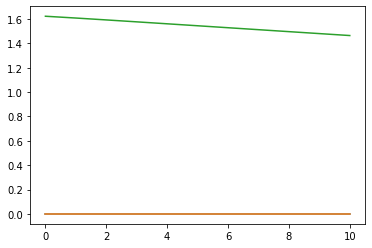

In [ ]:
plt.plot(losses)

In [ ]:
@tf.function
def toto():
    res = tf.TensorArray(tf.float32,size=10,dynamic_size=False,clear_after_read=False)
    res_dFnum=tf.TensorArray(tf.float32,size=10,dynamic_size=False,clear_after_read=False)

    for t in tf.range(10):
        W=tf.constant(1.)
        res.write(t,W)
        dFnum=tf.constant(2.)
        res_dFnum.write(t,dFnum)

    return res.stack(),res_dFnum.stack()


In [ ]:
a,b=toto()

In [ ]:
@tf.function
def conca():
    A=tf.ones([2,2])
    B=tf.ones([2,2])
    return tf.concat([A,B],axis=1)

In [ ]:
conca()

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[1., 1., 1., 1.],
       [1., 1., 1., 1.]], dtype=float32)>